## Lactate Discordance Project: Exploratory Analysis of Lactate in MIMIC-III by Illness Severity
### C.V. Cosgriff

This notebook extracts the maximum lactate in the first 24 hours for all patients in the MIMIC-III. After excluding patients with length of stay below four hours, those lacking data, and those under the age of 16, the lactate levels are grouped using deciles of the OASIS score and then the distribution is plotted.

## 0 - Environment Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2

sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

dbname = 'mimic'
schema_name = 'mimiciii'
query_schema = 'SET search_path TO ' + schema_name + ';'

con = psycopg2.connect(dbname=dbname)

## 1 - Extraction

Extract data from SQL database. Note we're using `labsfirstday`, `icustay_detail`, and `OASIS` materialized view.

In [2]:
query = query_schema + '''
  SELECT ied.icustay_id, ied.admission_age, la.lactate_max
         , os.oasis, ied.los_icu, ied.hospital_expire_flag         
FROM icustay_detail ied
LEFT JOIN labsfirstday la
    ON ied.icustay_id = la.icustay_id
INNER JOIN oasis os
    ON ied.icustay_id = os.icustay_id;
'''

base_cohort = pd.read_sql_query(query, con)
display(base_cohort.head())
print(base_cohort.shape)

,icustay_id,admission_age,lactate_max,oasis,los_icu,hospital_expire_flag
0,243653,0.0022,NaN,15,0.0918,0
1,211552,76.5268,8.8,57,6.0646,0
2,294638,47.8450,2.1,26,1.6785,0
3,214757,0.0005,NaN,9,0.0844,0
4,228232,65.9407,NaN,11,3.6729,0


(61051, 6)


Limit cohort to those who have a lactate, an APACHE IVa score, are age >16, and have a LoS greater than 4 hours.

In [3]:
base_cohort.loc[base_cohort.admission_age >= 90, 'admission_age'] = 91.3

include = (base_cohort.loc[:, 'admission_age']) > 16
include = include & (~pd.isna(base_cohort.loc[:, 'oasis']))
include = include & (~pd.isna(base_cohort.loc[:, 'lactate_max']))
incldue = include & (base_cohort.loc[:, 'los_icu'] >= 0.167)
cohort = base_cohort.loc[include, ['icustay_id', 'oasis', 'lactate_max']]

## 2 - Analysis

We then create deciles of the APACHE IVa score and assign each patient stay to a category. 

In [4]:
oasis_category = pd.qcut(x=cohort.oasis, q=np.arange(0, 1.1, 0.1), labels=np.arange(1, 11, 1))
cohort = cohort.assign(oasis_category=oasis_category)
cohort.loc[:, ['oasis_category', 'lactate_max']].groupby('oasis_category').describe()

lactate_max                                              
                     count      mean       std  min  25%  50%  75%   max
oasis_category                                                          
1                   3359.0  2.377315  2.029670  0.3  1.2  1.8  2.8  29.0
2                   3806.0  2.507194  1.896135  0.3  1.4  2.0  3.0  26.4
3                   2411.0  2.581829  1.941307  0.4  1.4  2.1  3.1  22.7
4                   3990.0  2.654053  2.103099  0.4  1.4  2.1  3.1  27.7
5                   2781.0  2.877012  2.211559  0.4  1.5  2.2  3.5  31.0
6                   2709.0  2.817383  2.080129  0.3  1.5  2.2  3.4  19.0
7                   3537.0  2.965770  2.344839  0.4  1.5  2.3  3.6  22.7
8                   2857.0  3.173945  2.705717  0.4  1.6  2.3  3.6  27.1
9                   2635.0  3.520934  3.019612  0.4  1.6  2.5  4.3  32.0
10                  3052.0  4.561877  4.007645  0.5  1.8  3.1  5.9  29.3

We can plot the above distributions.

/home/cvc/env/ML/lib/python3.6/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/cvc/env/ML/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'Distribution of Maximum Lactate on Day 1, Grouped by OASIS Decile')

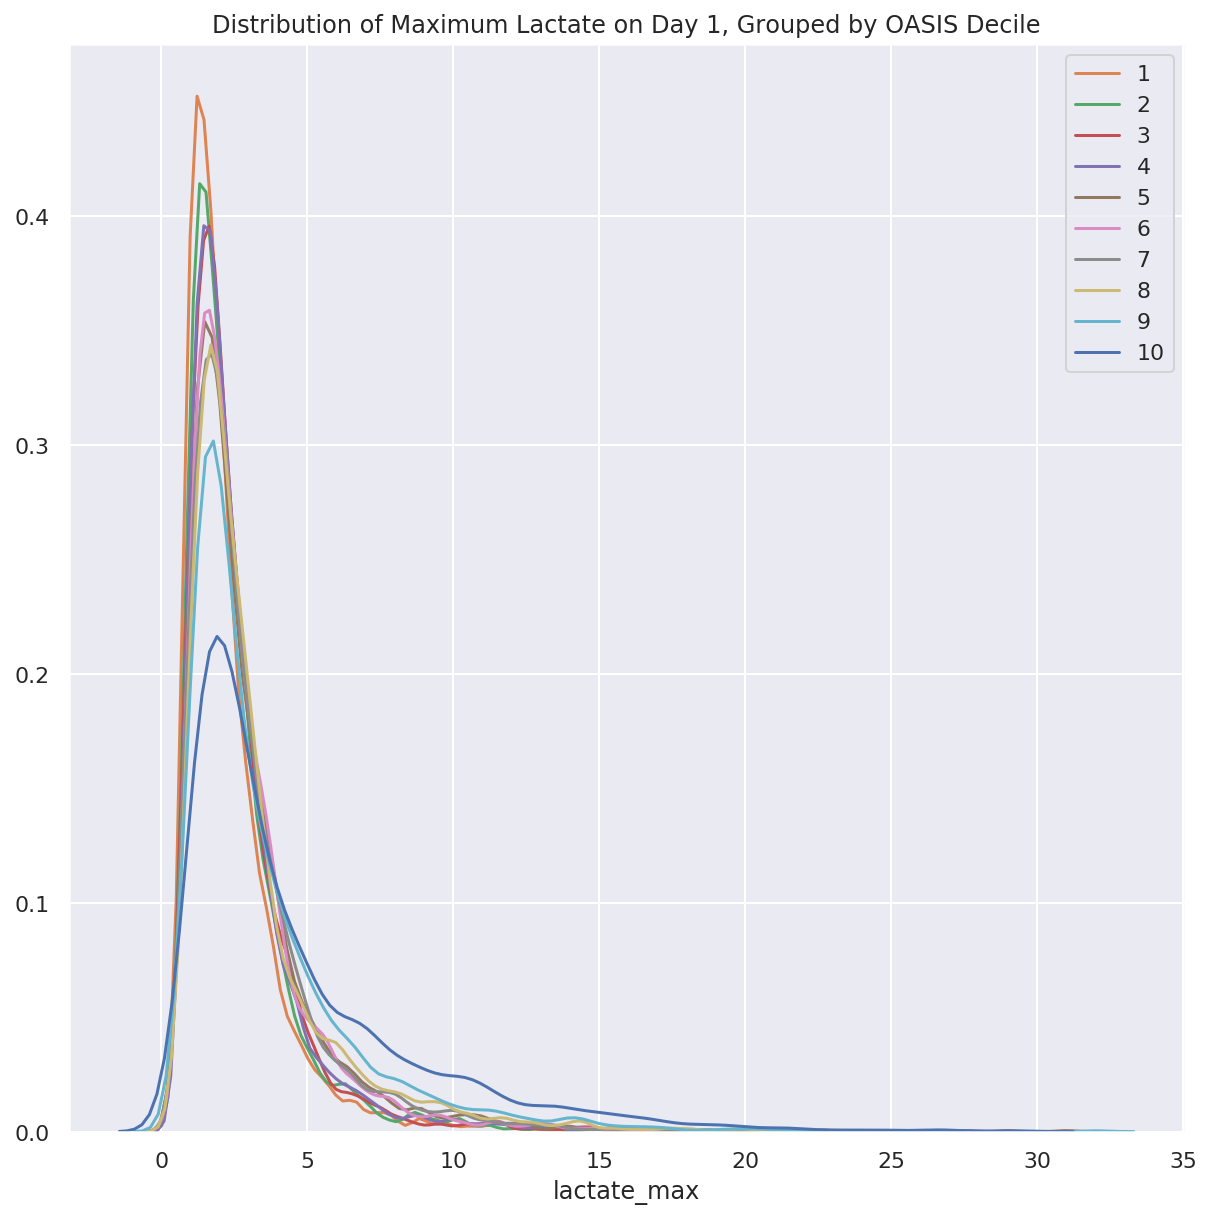

In [5]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
for i in range(11):
    sns.distplot(cohort.loc[cohort.oasis_category == i, 'lactate_max'], hist=False, ax=ax, label=i)
plt.legend()
plt.title('Distribution of Maximum Lactate on Day 1, Grouped by OASIS Decile')

We can also answer the question, "within each decile, how many patient's have a _normal_ lactate?"

Text(0, 0.5, 'Proportion with Normal Lactate')

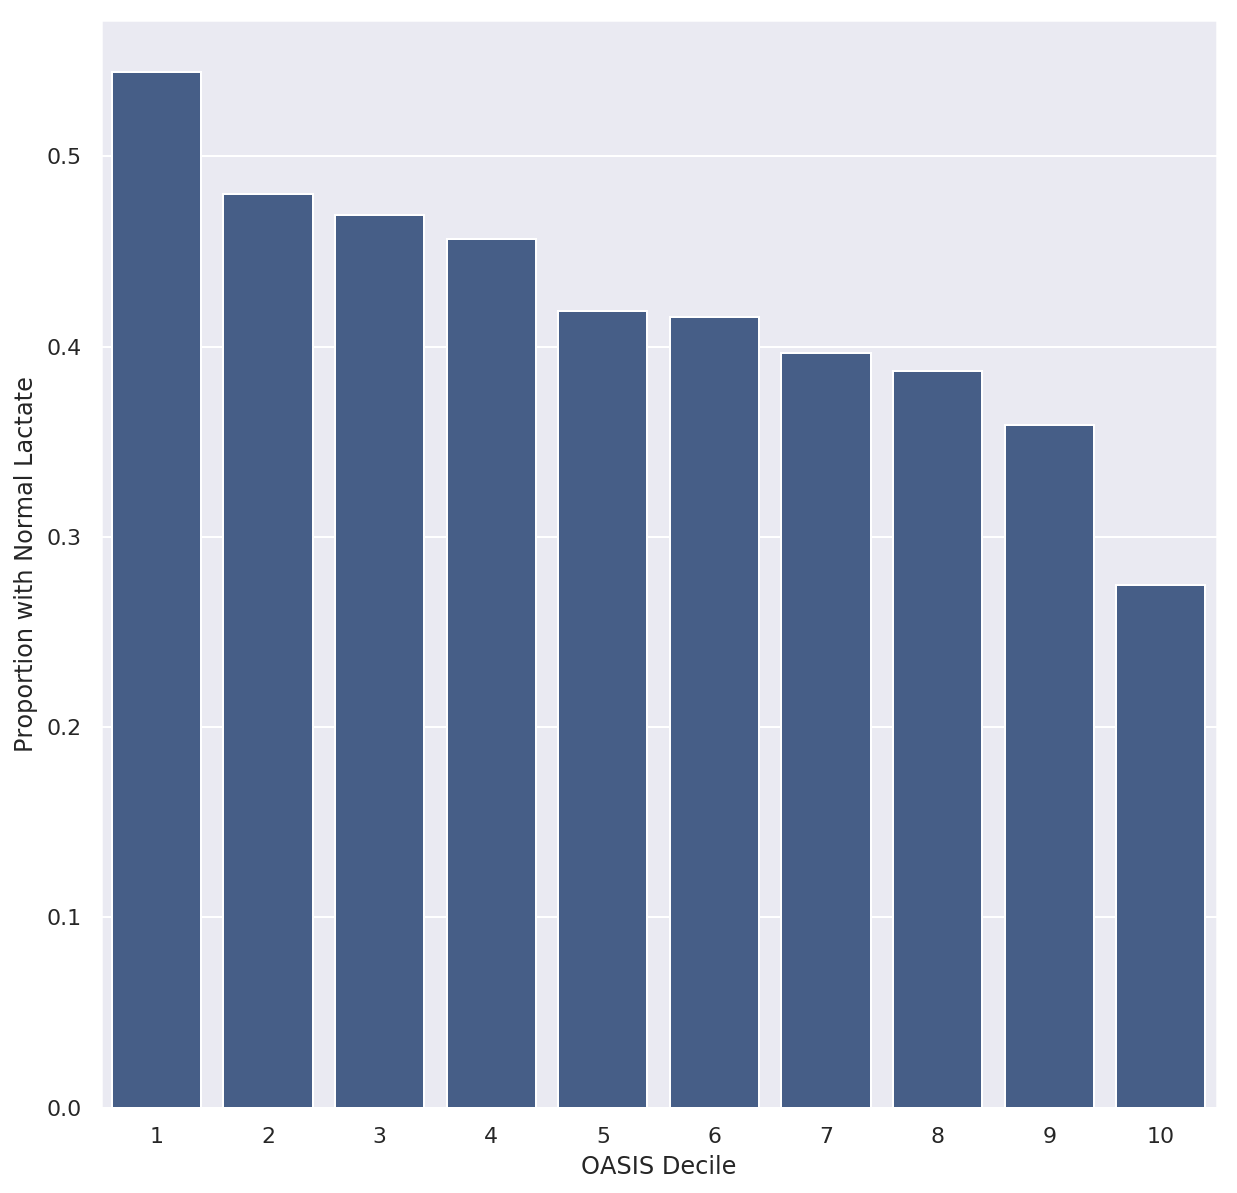

In [6]:
def normal_lactate(x):
    return (x < 2).mean()

normal_lac_prop = [normal_lactate(cohort.loc[cohort.oasis_category == i, 'lactate_max']) for i in range(1,11)]

fig, ax = plt.subplots()
fig.set_size_inches(10,10)
sns.barplot(x=np.arange(1,11), y=normal_lac_prop, color=sns.xkcd_rgb['denim blue'], ax=ax)
plt.xlabel('OASIS Decile')
plt.ylabel('Proportion with Normal Lactate')

With the analysis done, we close the database connection.

In [7]:
con.close()